In [2]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import re

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
import pdftotext
import pickle

In [3]:
##### Functions for cleaning text, extracting skills #####
# Get raw text from file
def getRawText(filepath):
    with open(filepath, "rb") as f:
        pdf = pdftotext.PDF(f)
    resume_text = ("\n\n".join(pdf))
    return resume_text

# STOPWORD REMOVAL
def stopword(string):
    a = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    # Get position tags
    word_pos_tags = pos_tag(word_tokenize(string))
    # Map the position tag and lemmatize the word/token
    a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return ' '.join(a)

# Clean Text Function
def getCleanText(text):
    pat = '[a-zA-Z]+'
    i = 0
    newtext = ''
    for EachLine in text:
        newtext += EachLine.lower()
    # newtext = remove_noneng_nonskill(newtext)
    newtext = stopword(newtext)
    newtext = lemmatizer(newtext)
    # newtext = remove_noneng_nonskill(newtext)
    newtext_lst = re.findall(pat, newtext)
    # print(newtext_lst)
    if len(newtext_lst) <= 20:
        return " ".join(newtext_lst[0:len(newtext_lst)])
    else:
        return " ".join(newtext_lst[9:len(newtext_lst)])

In [4]:
# change the file paths accordingly to where the files will be
jd_path = "/Users/weils/Downloads/Telegram Desktop/Final Model for Integration/files/jd/"
resume_path = "/Users/weils/Downloads/Telegram Desktop/Final Model for Integration/files/resume/"

jd_files = [f for f in listdir(jd_path) if ".pdf" in f]
resume_files = [f for f in listdir(resume_path) if ".pdf" in f]

print(len(jd_files))
print(len(resume_files))

3
134


In [5]:
def getLabel (filename):
    if "Not Suitable" in filename or "Rejected" in filename:
        return 0
    else:
        return 1

def getJobFileName(resume_filename):
    if "Field Support" in resume_filename:
        return "Job Description - Field Support Engineer.pdf"
    elif "System Analyst" in resume_filename:
        return "Job Description - System Analyst.pdf"
    else:
        return "Job Description - GPIS Executive.pdf"

In [22]:
output = []
for resume in resume_files:
    jobfilename = getJobFileName(resume)
    jd_text = getRawText(jd_path + jobfilename)
    resume_text = getRawText(resume_path + resume)
    
    jd_cleaned_text = getCleanText(jd_text)
    resume_cleaned_text = getCleanText(resume_text)
    label = getLabel(resume)

    data = [jd_cleaned_text, resume_cleaned_text, label]
    output.append(data)

data = pd.DataFrame(output, columns = ["JD Text", "Resume Text", "Label"])
print(data)

                                               JD Text  \
0    manager source best rate shipment feedback bus...   
1    manager source best rate shipment feedback bus...   
2    manager source best rate shipment feedback bus...   
3    manager source best rate shipment feedback bus...   
4    manager source best rate shipment feedback bus...   
..                                                 ...   
129  manager source best rate shipment feedback bus...   
130  manager source best rate shipment feedback bus...   
131  manager source best rate shipment feedback bus...   
132  manager source best rate shipment feedback bus...   
133  manager source best rate shipment feedback bus...   

                                           Resume Text  Label  
0    pte ltd july present receiving shipping coordi...      0  
1    portal baan system acrobat adobe microsoft off...      0  
2    compliance officer investigate recommend enfor...      0  
3    freight forward branch different key role 

In [7]:
X, y = data[["JD Text", "Resume Text"]], data["Label"]

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(np.shape(X_train))
print(np.shape(y_train))

(107, 2)
(107,)


In [9]:
# since there are 2 columns of text data, just using TfidfVectorizer() in the pipeline does not work
# source: https://stackoverflow.com/questions/67768470/valueerror-found-input-variables-with-inconsistent-numbers-of-samples-6-80

transformer = ColumnTransformer(
    [('jd', TfidfVectorizer(), "JD Text"),  # col_1 should be a string or int
     ('resume', TfidfVectorizer(), "Resume Text")],   # col_n should be a string or int
    remainder='passthrough')
    
textclassifier = Pipeline([
   ('tfidf', transformer),
   ('smote', SMOTE(sampling_strategy='not majority', k_neighbors=2, random_state=42)),
   ('svm', svm.SVC(kernel='poly', gamma='auto', probability = True))
])

In [10]:
textclassifier.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('jd', TfidfVectorizer(),
                                                  'JD Text'),
                                                 ('resume', TfidfVectorizer(),
                                                  'Resume Text')])),
                ('smote',
                 SMOTE(k_neighbors=2, random_state=42,
                       sampling_strategy='not majority')),
                ('svm', SVC(gamma='auto', kernel='poly', probability=True))])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        18
           1       0.50      0.11      0.18         9

    accuracy                           0.67        27
   macro avg       0.59      0.53      0.49        27
weighted avg       0.62      0.67      0.59        27

SVM Accuracy Score ->  66.66666666666666
Cross Validation accuracy scores: [0.81818182 0.81818182 0.63636364 0.45454545 0.81818182 0.72727273
 0.72727273 0.8        0.7        0.7       ]
Cross Validation accuracy: 0.720 +/- 0.107


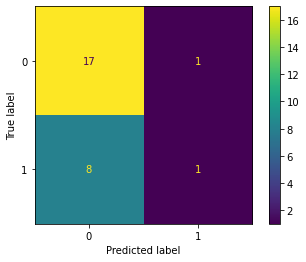

In [49]:
# predict the labels on validation dataset
predictions = textclassifier.predict(X_test)
print(predictions)

# Classification report
print(classification_report(y_test, predictions))

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ", accuracy_score(predictions, y_test)*100)

# Confusion matrix
plot_confusion_matrix(textclassifier, X_test, y_test)

scores = model_selection.cross_val_score(textclassifier, X_train, y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

In [12]:
# save the trained model into a pickle file
no_class_model = pickle.dump(textclassifier, open('no_class_model.pkl', 'wb'))

In [14]:
# load the pickle file
loaded_classifier = pickle.load(open('no_class_model.pkl', 'rb'))

In [46]:
### test to see if the pickle file works
# get jd text
raw_jd = getRawText("Job Description - Field Support Engineer.pdf")
clean_jd = getCleanText(raw_jd)

# get resume text
raw_resume = getRawText("Sample Field Support CV 1 (ML - Selected).pdf")
clean_resume = getCleanText(raw_resume)

X_predict = [clean_jd, clean_resume]
X_predict = pd.DataFrame([X_predict], columns=["JD Text", "Resume Text"])


In [47]:
pkl_predictions = loaded_classifier.predict(X_predict)

In [48]:
print(pkl_predictions)

[0]
